In [10]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [112]:
from functions import *

In [87]:
#GRAPH STRUCTURE OPTIMIZATION TEST
x = np.linspace(0,math.pi,100)
y = np.sin(x)#2*x+1
data = {"x":x,"y":y}

In [124]:
%lprun -f evolution evolution(data)

/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:271: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON


evolving generation 0 of 20
killed :15


/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: invalid value encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]


min error at generation n.0: 12.3819135315
evolving generation 1 of 20
killed :15
min error at generation n.1: 12.5127409118
evolving generation 2 of 20
killed :15
min error at generation n.2: 20.3277589554
evolving generation 3 of 20
killed :15
*** KeyboardInterrupt exception caught in code being profiled.

In [14]:
result = {'specimen': [{'lib_id': 2, 'input': [6, 1]}, {'lib_id': 3, 'input': [3, 6]}, {'arg_index': 0, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [2, 4]}, {'lib_id': 3, 'input': [6, 6]}, {'arg_index': 1, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [5, 7]}, {'lib_id': 3, 'input': [9, 9]}, {'arg_index': 2, 'lib_id': 0, 'input': []}, {'lib_id': 2, 'input': [8, 11]}, {'arg_index': 3, 'lib_id': 0, 'input': []}, {'lib_id': 3, 'input': [10, 8]}], 'error': 6.8198719261941951}

In [15]:
def export_json_graph(graph):
    import json
    import networkx as nx
    from io import StringIO
    from networkx.readwrite import json_graph

    G =nx.MultiDiGraph()

    for n, node in enumerate(graph):
        G.add_node(n, attr_dict=node)

    for n1, node in enumerate(graph):
        for i, n2 in enumerate(node["input"]):
            G.add_edge(n2, n1, attr_dict={"arg":i})

    json_data = json_graph.node_link_data(G)

    for n, node in enumerate(json_data["nodes"]):
        symbol = lib[node["lib_id"]]["symbol"]

        if symbol == "v":
            symbol = node["arg_index"]

        json_data["nodes"][n] = {"id":node["id"], "symbol":symbol}

    
    with open("graph.json", "w") as json_file:
        json.dump(json_data, json_file)
    

/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  {"type":"function","function":lambda a:a[0]/a[1],"symbol":"/"}]
/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:271: RuntimeWarning: invalid value encountered in subtract
  grad = (value_there-value_here)/EPSILON
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/david/anaconda/lib/pyt

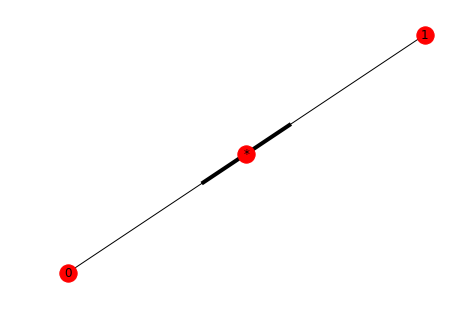

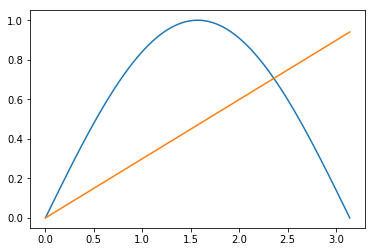

evolving generation 0 of 20
<generator object evolution.<locals>.<genexpr> at 0x118ac69e8>
min error at generation n.0: 13.2798547132
evolving generation 1 of 20
<generator object evolution.<locals>.<genexpr> at 0x118ac69e8>


AttributeError: 'list' object has no attribute 'unfitness'

In [117]:
%%time
e = evolution(data)
print(e)
# Export resulting graph to json file
# You can view it by starting a webserver(python2 -m SimpleHTTPServer) and then going to http://localhost:8000/graph_viewer.html
export_json_graph(e["specimen"])
print("fittest specimen:")
draw(e["specimen"])
plot_optimized(e["specimen"],data)

In [22]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
%lprun -f optimize optimize(lib[7]["graph"],data,0)

{'iterations': 51, 'parameters': array([ 0.81006931,  2.04725724]), 'error': 7.5945441550180899, 'X': 0}


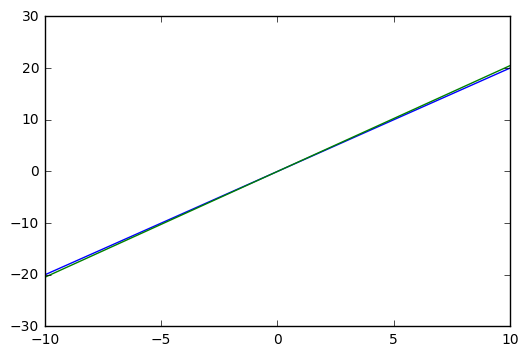

In [416]:
#GRAPH PARAMETER OPTIMIZATION TEST
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
pylab.plot(x,y)
data = {"x":x,"y":y}
#lib[7] is the A*B graph
result = optimize(lib[7]["graph"],data,0)
print(result)
values = result["parameters"]
x_pos = result["X"]
#input_size*number_of_data_points matrix that contains a list of input vectors like [parameter1, parameter2, x_value, ...]
value_matrix = [[(xe if v == x_pos else value) for v, value in enumerate(values)] for xe in x]
y = np.array([ evaluate(lib[7]["graph"],value_matrix[i]) for i in range(len(value_matrix)) ])
pylab.plot(x,y)
pylab.show()

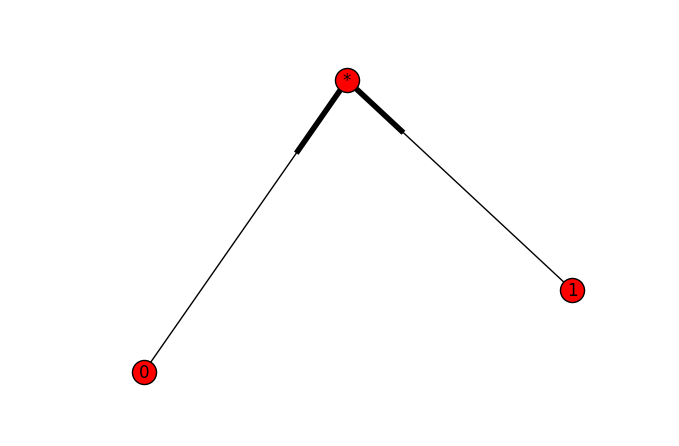

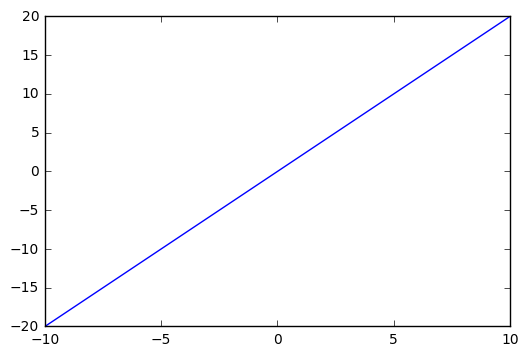

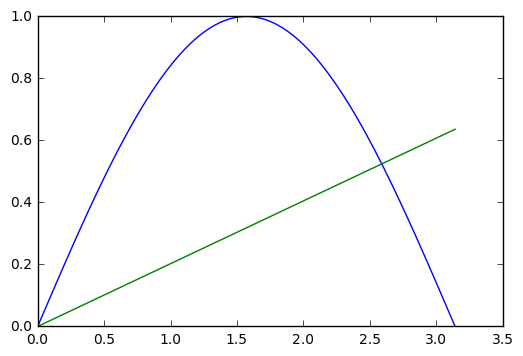

In [352]:
draw(lib[7]["graph"])
plot_specimen(lib[7]["graph"],[2,2])
pylab.close()
x = np.linspace(-10,10,100)
y = 2*x
plot_optimized(lib[7]["graph"],data)

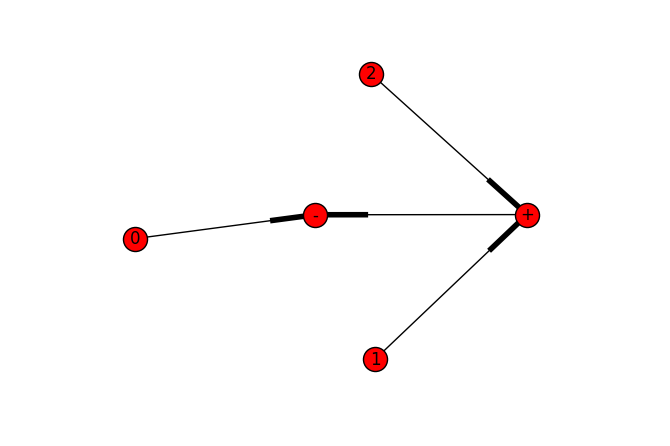

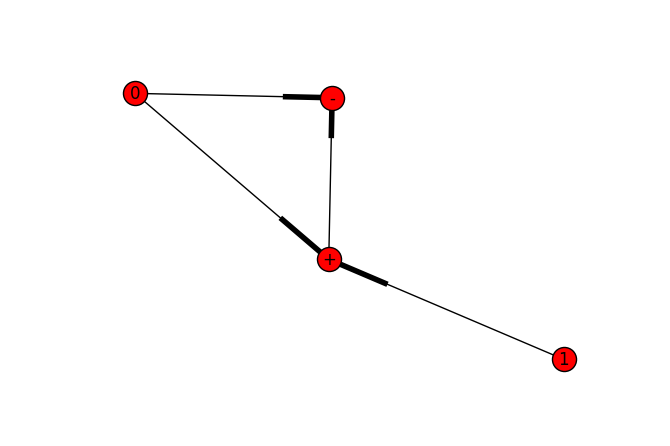

In [353]:
g3 = insert_at(lib[5]["graph"],lib[6]["graph"])
draw(g3)
g4 = merge_input_entries(g3)
draw(g4)

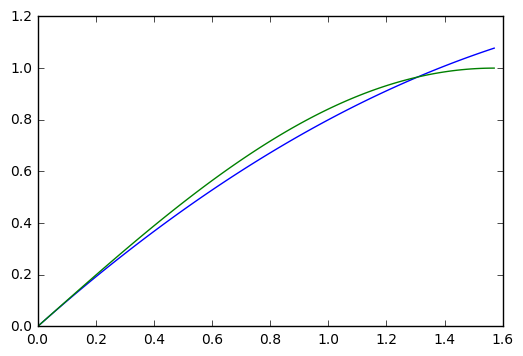

In [357]:
pylab.close()
x = np.linspace(0,math.pi/2,100)
y = x-0.2*x**2
pylab.plot(x,y)
y = np.sin(x)
pylab.plot(x,y)
pylab.show()